In [ ]:
import pandas as pd

df = pd.read_pickle('longevity/pubmed_longevity.pkl')

In [2]:
import string
import ast

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH

from textsemantics import specific_words
from utils.cluster_utils import find_cluster_words

import numpy as np
from umap import UMAP
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from IPython.display import Markdown, display

from sklearn.feature_extraction.text import TfidfVectorizer
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from sklearn.mixture import GaussianMixture
from collections import Counter

In [3]:
%%time
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
texts = [' '.join(t) for t in tokens_list if len(t) > 0]
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

2021-04-06 16:39:35,980 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-news-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpsg0sgqj8


100%|██████████| 1200000128/1200000128 [01:54<00:00, 10521283.56B/s]

2021-04-06 16:41:30,907 copying /tmp/tmpsg0sgqj8 to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M.vectors.npy


2021-04-06 16:41:35,922 removing temp file /tmp/tmpsg0sgqj8
2021-04-06 16:41:37,637 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-news-300d-1M not found in cache, downloading to /tmp/tmpvzqh8t5h


100%|██████████| 54600983/54600983 [00:11<00:00, 4765594.19B/s]

2021-04-06 16:41:50,035 copying /tmp/tmpvzqh8t5h to cache at /root/.flair/embeddings/en-fasttext-news-300d-1M


2021-04-06 16:41:50,118 removing temp file /tmp/tmpvzqh8t5h
2021-04-06 16:42:06,658 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:08,151 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:10,436 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:11,203 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:11,322 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:12,900 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-04-06 16:42:15,352 Warning: An empty Sentence was created! Are there empty strings in your dataset?
CPU times: user 2min 12s, sys: 18.6 s, total: 2min 31s
Wall time: 4min 6s


Number of clusters: 6, Noise: 4


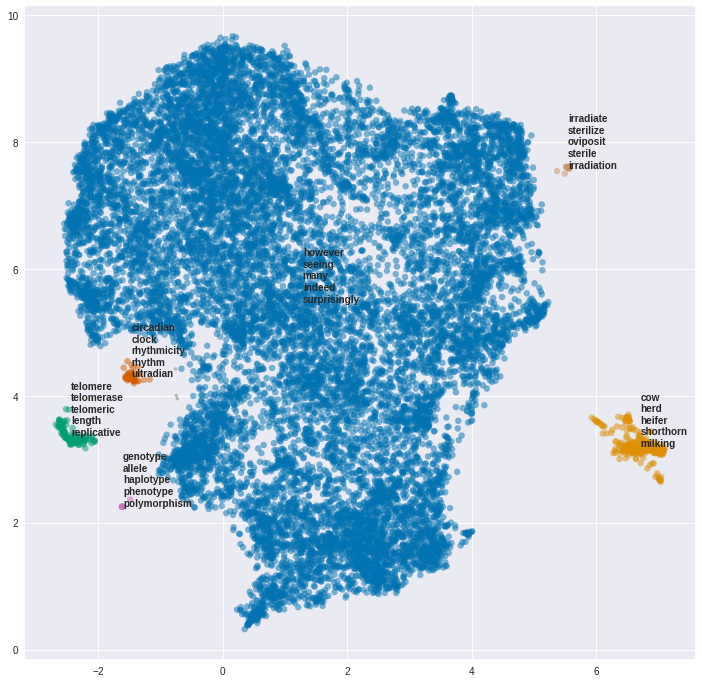

In [4]:
plt.figure(figsize=(12, 12))
plt.style.use('seaborn')

umap = UMAP(random_state=0).fit(doc_embs)

dbscan = DBSCAN(eps=0.2).fit(umap.embedding_)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
palette = sns.color_palette('colorblind', n_clusters)
print(f"Number of clusters: {n_clusters}, Noise: {n_noise}")


cluster_describer = find_cluster_words(doc_embs, word_embs, dbscan.labels_)

cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in dbscan.labels_]
s = [36 if l > -1 else 9 for l in dbscan.labels_]
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=cs,
            alpha=0.5, s=s);

for cluster, words in cluster_describer.items():
    centroid = np.mean(umap.embedding_[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(cluster_describer[cluster][:5])
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})


In [5]:
md = ''
for cluster, desc in cluster_describer.items():
    docs = np.where(labels == cluster)[0]
    negative = np.where(labels != cluster)[0]
    titles = df['title'].iloc[negative]

    idx = list()
    for kw in desc[:10]:
        idx.extend(t for t in titles if kw in t)

    other = len(set(idx))
    md += f'\n## Cluster {cluster}  - {len(docs)} documents \n'
    md += f'### Keywords: {", ".join(desc[:10])}\n'
    md += f'#### Keywords in titles of other clusters: {other}\n'
    
    for doc in docs[:10]:
        md += f"- {df['title'].iloc[doc]}\n"

display(Markdown(md))


## Cluster 0  - 16264 documents 
### Keywords: however, seeing, many, indeed, surprisingly, yet, nevertheless, potentially, following, seemingly
#### Keywords in titles of other clusters: 4
- The practice of self-preserving behavior of the citizen of the Russian Federation: the results of the All-Russian sociological study "The demographic self-feeling of Russia"
- Efficacy, longevity, and bleaching sensitivity of carbamide and hydrogen peroxides for in-office bleaching: A 6-month randomized, double blind, split-mouth clinical trial.
- Consumption of field-realistic doses of a widely used mito-toxic fungicide reduces thorax mass but does not negatively impact flight capacities of the honey bee (Apis mellifera).
- Calcium channel ITPR2 and mitochondria-ER contacts promote cellular senescence and aging.
- Analysis of distribution characteristics and influencing factors of healthy and long-lived people in Shanglin area of Nanning, Guangxi Zhuang Autonomous Region
- The study on the distribution characteristics and relevant factors of healthy and long-lived people in multiple regions of Guangxi Zhuang Autonomous Region
- SVIP is a molecular determinant of lysosomal dynamic stability, neurodegeneration and lifespan.
- Casein-maltodextrin Maillard conjugates encapsulation enhances the antioxidative potential of proanthocyanidins: An in vitro and in vivo evaluation.
- Aging and Senescence across Reproductive Traits and Survival in Superb Fairy-Wrens (Malurus cyaneus).
- Steroid hormones sulfatase inactivation extends lifespan and ameliorates age-related diseases.

## Cluster 1  - 315 documents 
### Keywords: cow, herd, heifer, shorthorn, milking, calf, dairy, cattle, milker, pasture
#### Keywords in titles of other clusters: 26
- Comparison of performance of F1 Romanov crossbred ewes with wool and hair breeds during fall lambing and body weight and longevity through six production years.
- Invited review: Academic and applied approach to evaluating longevity in dairy cows.
- Changes in milk lactose content as indicators for longevity and udder health in Holstein cows.
- An index framework founded on the future profit potential of female beef cattle to aid the identification of candidates for culling.
- Apgar score or birthweight in Chihuahua dogs born by elective Caesarean section: which is the best predictor of the survival at 24 h after birth?
- Genetic associations between stayability and longevity in commercial crossbred sows, and stayability in multiplier sows.
- Culling reasons and risk factors in Estonian dairy cows.
- Productive life span and resilience rank can be predicted from on-farm first-parity sensor time series but not using a common equation across farms.
- Body weight of dairy heifers is positively associated with reproduction and stayability.
- Symposium review: Why revisit dairy cattle productive lifespan?

## Cluster 2  - 128 documents 
### Keywords: telomere, telomerase, telomeric, length, replicative, microtubule, cohesin, shortening, titin, senescence
#### Keywords in titles of other clusters: 391
- Stress-related changes in leukocyte profiles and telomere shortening in the shortest-lived tetrapod, Furcifer labordi.
- Born to be young? Prenatal thyroid hormones increase early-life telomere length in wild collared flycatchers.
- Mathematical Connection between Short Telomere Induced Senescence Calculation and Mortality Rate Data.
- Exploiting the telomere machinery to put the brakes on inflamm-aging.
- Mice with hyper-long telomeres show less metabolic aging and longer lifespans.
- Individual variation in early-life telomere length and survival in a wild mammal.
- Telomere shortening rate predicts species life span.
- Telomeres and Longevity: A Cause or an Effect?
- Do Telomeres Influence Pace-of-Life-Strategies in Response to Environmental Conditions Over a Lifetime and Between Generations?
- Alcohol consumption and leukocyte telomere length.

## Cluster 3  - 52 documents 
### Keywords: circadian, clock, rhythmicity, rhythm, ultradian, timekeeping, desynchronization, chronobiology, clockwork, rhythmic
#### Keywords in titles of other clusters: 56
- Resetting the Aging Clock: Implications for Managing Age-Related Diseases.
- Chronic circadian misalignment accelerates immune senescence and abbreviates lifespan in mice.
- Circadian gene variants and the skeletal muscle circadian clock contribute to the evolutionary divergence in longevity across Drosophila populations.
- Lifespan is unaffected by size and direction of daily phase shifts in Nasonia, a hymenopteran insect with strong circadian light resetting.
- Effects of MUL1 and PARKIN on the circadian clock, brain and behaviour in Drosophila Parkinson's disease models.
- Circadian clock genes' overexpression in Drosophila alters diet impact on lifespan.
- Rhythms of life: circadian disruption and brain disorders across the lifespan.
- Neuron-specific overexpression of core clock genes improves stress-resistance and extends lifespan of Drosophila melanogaster.
- Clock gene expression and locomotor activity predict death in the last days of life in Drosophila melanogaster.
- Circadian regulation of metabolism and healthspan in Drosophila.

## Cluster 4  - 8 documents 
### Keywords: genotype, allele, haplotype, phenotype, polymorphism, homozygosity, homozygote, multilocus, penetrance, immunogenetic
#### Keywords in titles of other clusters: 451
- The Science of Choosing Wisely: should it be applied to any intervention for healthy and active longevity?
- Lifespan of New Zealand Second World War veterans from one large cemetery: the case for a national-level study.
- Increased synthesis of a coenzyme linked to longevity can combat disease.
- Response to the letter sent by Dr. Viroj Wiwanitkit entitled "Coffee waste, vector control and dengue".
- Coffee waste, vector control, and dengue.
- Health challenges and perspectives for sub-Saharan Africa.
- Lithium treatment and mechanisms of aging.
- Clinical and genetic characteristics of long-livers in Moscow region

## Cluster 5  - 20 documents 
### Keywords: irradiate, sterilize, oviposit, sterile, irradiation, impregnate, medfly, female, inseminate, anaesthetise
#### Keywords in titles of other clusters: 392
- Combined sterile insect technique and incompatible insect technique: sex separation and quality of sterile Aedes aegypti male mosquitoes released in a pilot population suppression trial in Thailand.
- Effect of Gamma Irradiation on Fecundity, Sterility, and Female Sex Pheromone Production of Callosobruchus chinensis (Coleoptera: Bruchidae).
- Effects of Irradiation Dose on Sperm Production, Insemination, and Male Mating Possible Period in the Sweetpotato Weevil (Coleoptera: Brentidae).
- Sexual Competitiveness, Field Survival, and Dispersal of Anastrepha obliqua (Diptera: Tephritidae) Fruit Flies Irradiated at Different Doses.
- Irradiation biology of male brown marmorated stink bugs: is there scope for the sterile insect technique?
- The sterile insect technique for the management of the spotted wing drosophila, Drosophila suzukii: Establishing the optimum irradiation dose.
- Laboratory longevity and competitiveness of Dacus ciliatus Loew (Diptera: Tephritidae) following sub-sterilizing gamma irradiation.
- X-ray-induced sterility in Aedes albopictus (Diptera: Culicidae) and male longevity following irradiation.
- Evaluating irradiation dose for sterility induction and quality control of mass-produced fruit fly Bactrocera tryoni (Diptera: Tephritidae).
- Effects of radiation on inherited sterility in the European grapevine moth (Lobesia botrana).


## t-SNE + GMM

In [6]:
%%time

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
    callbacks=ErrorLogger(),
)

embedding_ = tsne.fit(doc_embs)

/usr/local/lib/python3.7/dist-packages/openTSNE/callbacks.py:55: FutureWarning: `ErrorLogger` will be removed in upcoming version. Please use the `verbose` flag instead.
  category=FutureWarning,


Iteration   50, KL divergence  3.1668, 50 iterations in 23.0588 sec
Iteration  100, KL divergence  3.1668, 50 iterations in 22.8699 sec
Iteration  150, KL divergence  3.1668, 50 iterations in 22.8741 sec
Iteration  200, KL divergence  3.1668, 50 iterations in 22.6415 sec
Iteration  250, KL divergence  3.1668, 50 iterations in 22.8917 sec
Iteration   50, KL divergence  2.0413, 50 iterations in 23.0767 sec
Iteration  100, KL divergence  1.8939, 50 iterations in 23.3215 sec
Iteration  150, KL divergence  1.8561, 50 iterations in 22.9804 sec
Iteration  200, KL divergence  1.8422, 50 iterations in 23.1273 sec
Iteration  250, KL divergence  1.8354, 50 iterations in 23.1987 sec
Iteration  300, KL divergence  1.8314, 50 iterations in 23.0107 sec
Iteration  350, KL divergence  1.8290, 50 iterations in 23.1904 sec
Iteration  400, KL divergence  1.8280, 50 iterations in 22.7589 sec
Iteration  450, KL divergence  1.8275, 50 iterations in 22.8309 sec
Iteration  500, KL divergence  1.8272, 50 iterat

In [7]:


def make_ellipses(gmm, ax):
    palette = sns.color_palette('colorblind', 8)
    colors = [palette[i] for i in range(gmm.n_components)]
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


def annotate_graph(points, labels, keywords, ax):
    num_kw = 15
    desc = dict()
    for i, cluster in enumerate(set(labels) - {-1}):
        cluster_idx = np.where(labels == cluster)[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
    
        clis = set(cluster_idx)
        all_kws = [kw for i, kws in enumerate(keywords) if i in clis for kw in kws[:num_kw]]
        c = Counter(all_kws).most_common(5)

        ann = "\n".join(w for w, _ in c) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'},
                va='center', ha='center')
        desc[i] = dict()
        desc[i]['idx'] = cluster_idx
        desc[i]['keywords'] = [w for w, _ in c]
    return desc


def tfidf_clusters(points, labels, keywords, ax, sublinear_tf=False):
    num_kw = 10
    clusters = list()
    for i, cluster in enumerate(set(labels) - {-1}):
        cluster_idx = np.where(labels == cluster)[0]
    
        clis = set(cluster_idx)
        all_kws = [kw for i, kws in enumerate(keywords) if i in clis for kw in kws[:num_kw]]
        clusters.append(all_kws)

    vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False,
                                 sublinear_tf=sublinear_tf)
    X = vectorizer.fit_transform(clusters)
    words = vectorizer.get_feature_names()
    # print(words)
    desc = dict()
    for i, (row, cluster) in enumerate(zip(X, set(labels) - {-1})):
        cluster_idx = np.where(labels == cluster)[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        clis = set(cluster_idx)

        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords = sorted(features, key=lambda tup: tup[1], reverse=True)
        ann = '\n'.join([w for w, _ in keywords[:5]]) + f'\n\n{i+1}'
        
        desc[i] = dict()
        desc[i]['idx'] = cluster_idx
        desc[i]['keywords'] = [w for w, _ in keywords[:5]]

        ax.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'},
                va='center', ha='center')
        
    return desc


def create_plot(kw, ellipses=True, title='', tfidf=False, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    if ellipses:
        make_ellipses(estimator, ax)

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    palette = sns.color_palette('colorblind', 8)

    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.5, s=s);

    if not tfidf:
        desc = annotate_graph(embedding_, labels, kw, ax)
    else:
        desc = tfidf_clusters(embedding_, labels, kw, ax, sublinear_tf)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title + f" (Number of Gaussians: 8, n_noise: {n_noise})")

    return desc

In [8]:
tfidf_kw = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

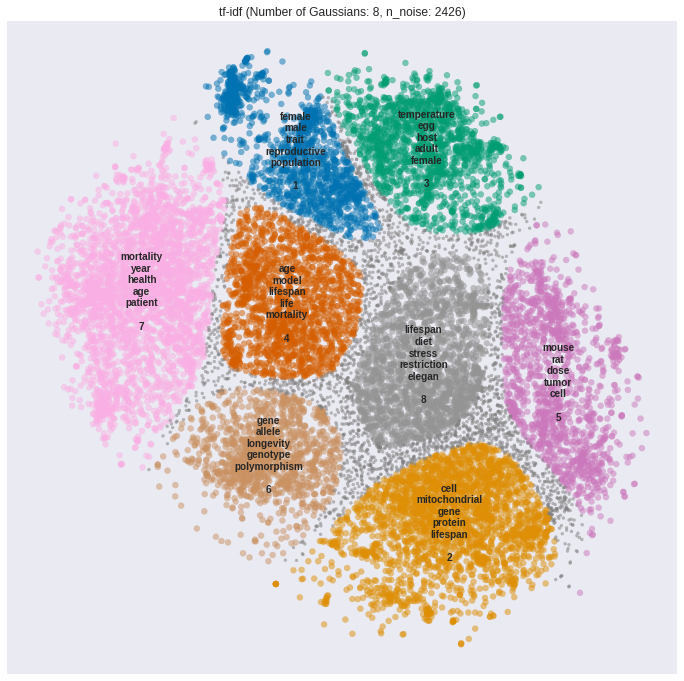

In [9]:
tfidf_desc = create_plot(tfidf_kw, ellipses=False, title='tf-idf')

In [10]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 14min 6s, sys: 9.8 s, total: 14min 16s
Wall time: 14min 19s


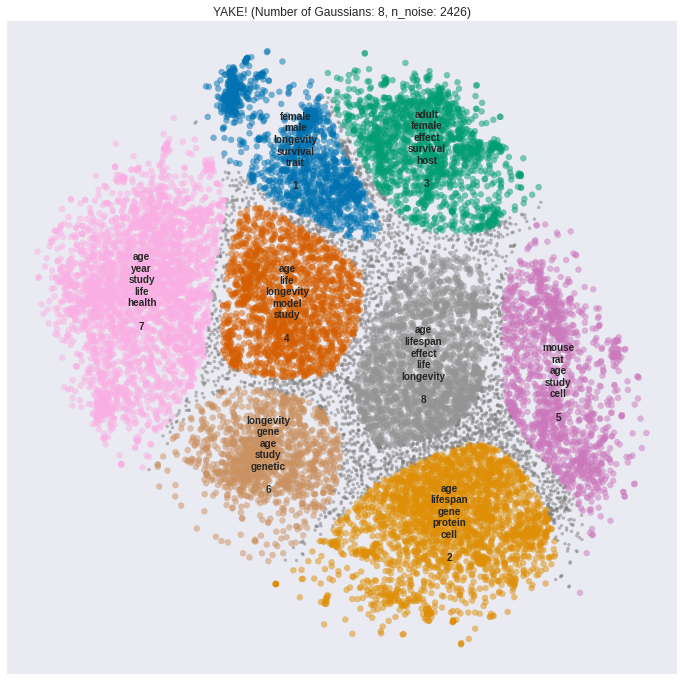

In [11]:
yake_desc = create_plot(yake_keywords, ellipses=False, title='YAKE!')

In [12]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=2)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    # return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]
    return kw

yake_phrases = [yake_method(txt) for txt in df["abstract"]]
yake_phrases = [[x for x, _ in wds] for wds in yake_phrases]

CPU times: user 24min 12s, sys: 15.2 s, total: 24min 27s
Wall time: 24min 26s


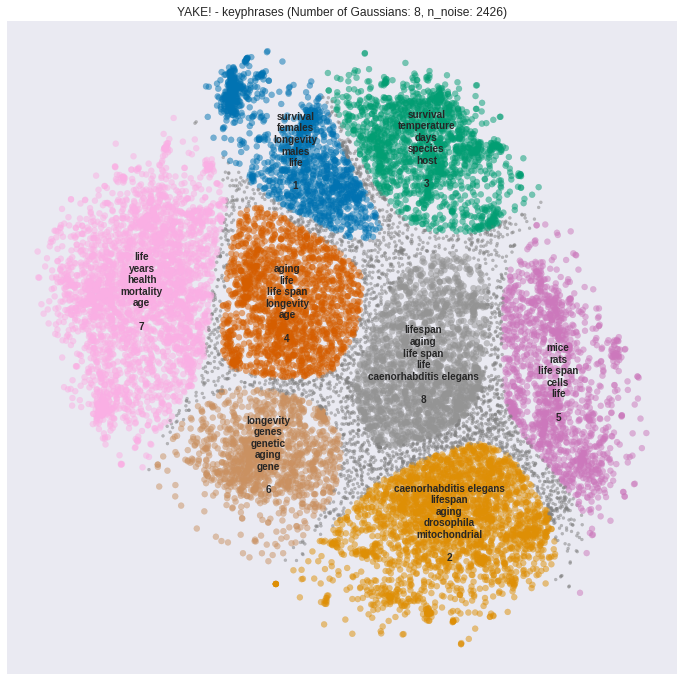

In [13]:
yake_phrase_desc = create_plot(yake_phrases, ellipses=False, title='YAKE! - keyphrases')

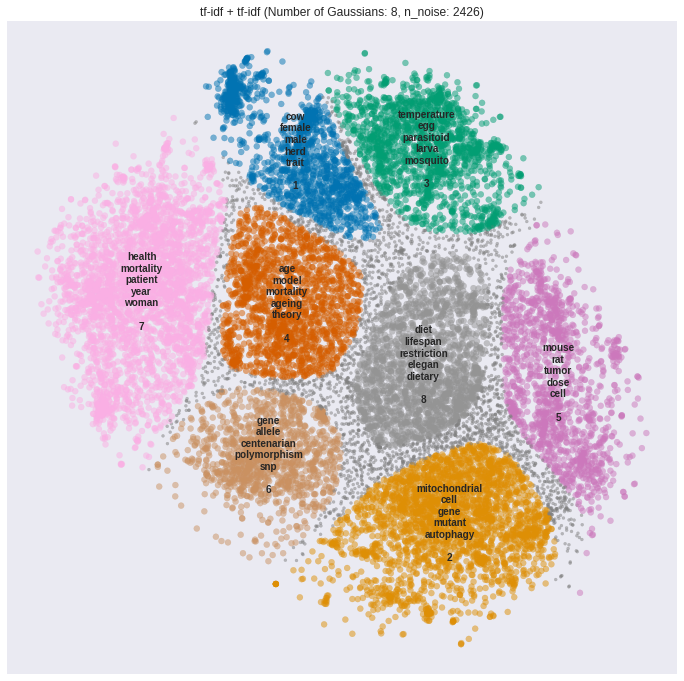

In [14]:
tfidf_tfidf_desc = create_plot(tfidf_kw, ellipses=False, title='tf-idf + tf-idf', tfidf=True)

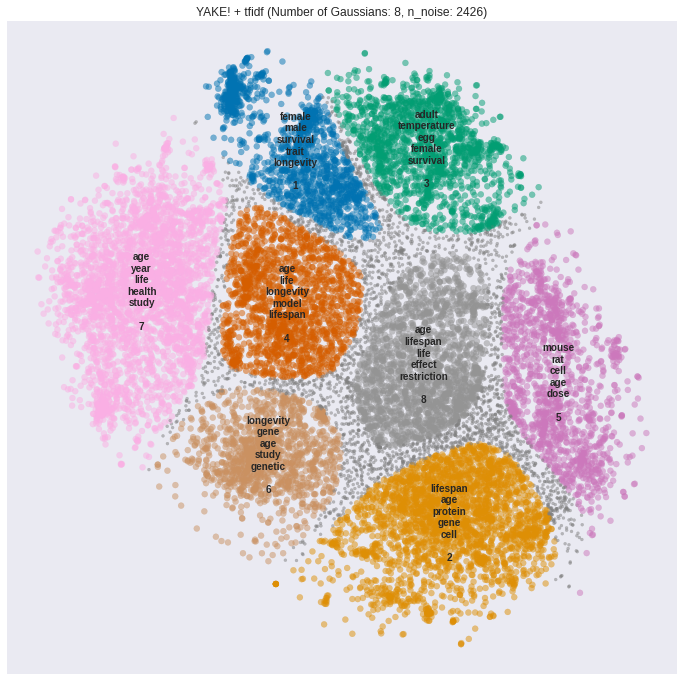

In [15]:
yake_tfidf_desc = create_plot(yake_keywords, ellipses=False, title='YAKE! + tfidf', tfidf=True)

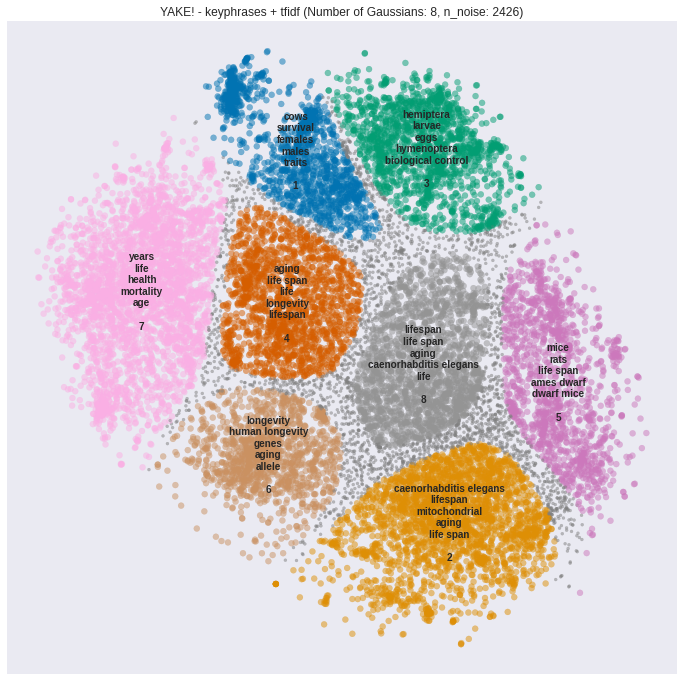

In [16]:
yake_phrase_tfidf_desc = create_plot(yake_phrases, ellipses=False, title='YAKE! - keyphrases + tfidf', tfidf=True)

In [17]:
descs = [tfidf_desc, yake_desc, yake_phrase_desc, tfidf_tfidf_desc, yake_tfidf_desc, yake_phrase_tfidf_desc]
names = ['tfidf', 'yake', 'yake_phrase', 'tfidf_tfidf', 'yake_tfidf', 'yake_phrase_tfidf']
final = dict()

for cluster in descs[0].keys():
    final[cluster + 1] = dict()
    for name, desc in zip(names, descs):
        final[cluster + 1][name] = desc[cluster]['keywords']
        final[cluster + 1]['idx'] = desc[cluster]['idx']
 

In [18]:
import pickle

with open('/content/longevity_cluster_data.pkl', 'wb') as f:
    pickle.dump(final, f)

{0: {'idx': array([    8,    20,    25, ..., 16674, 16755, 16763]),
  'keywords': ['herd', 'cow', 'heifer', 'ewe', 'stayability']},
 1: {'idx': array([    3,     6,     9, ..., 16580, 16649, 16771]),
  'keywords': ['histone', 'ribosomal', 'uprmt', 'autophagy', 'regulator']},
 2: {'idx': array([    1,     2,    32, ..., 16768, 16778, 16779]),
  'keywords': ['pollen', 'mite', 'tick', 'imidacloprid', 'urtica']},
 3: {'idx': array([   29,    37,    42, ..., 16764, 16773, 16781]),
  'keywords': ['parametric', 'gompertz', 'deep', 'equation', 'statistical']},
 4: {'idx': array([   88,   229,   292, ..., 16777, 16782, 16789]),
  'keywords': ['adenoma', 'mgkgday', 'neutron', 'mgkg', 'marrow']},
 5: {'idx': array([   78,    81,   126, ..., 16704, 16736, 16783]),
  'keywords': ['haplogroup', 'mtdna', 'epsilon4', 'gbe', 'lli']},
 6: {'idx': array([    0,     4,     5, ..., 16784, 16786, 16790]),
  'keywords': ['socioeconomic',
   'hospital',
   'public',
   'diagnosis',
   'inequality']},
 7: {'id

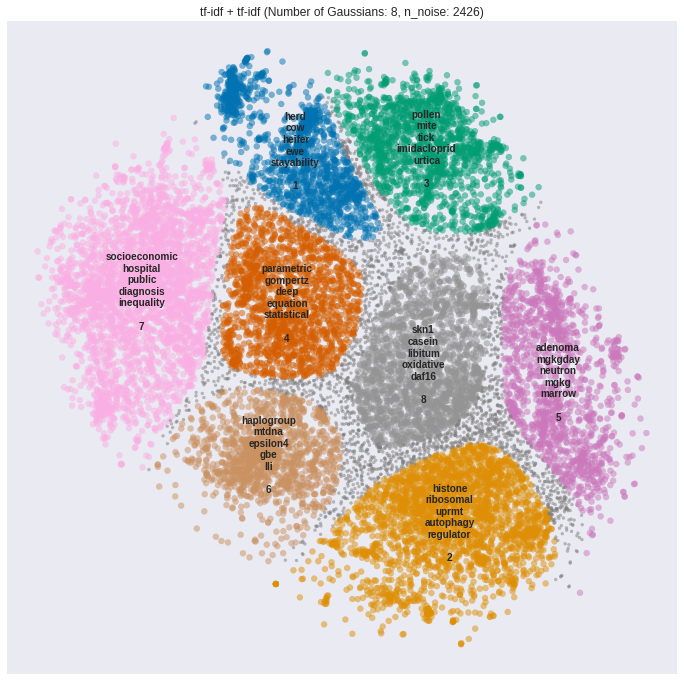

In [19]:
create_plot(tfidf_kw, ellipses=False, title='tf-idf + tf-idf', tfidf=True, sublinear_tf=True)

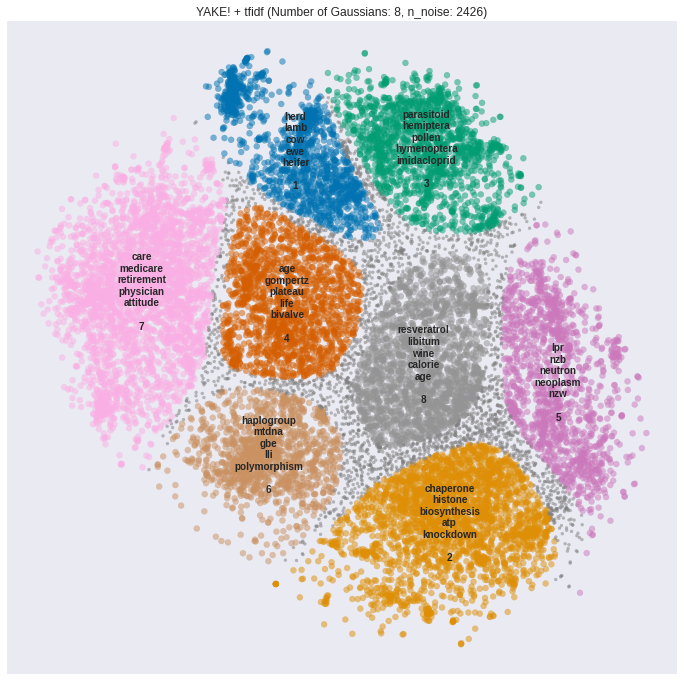

In [20]:
_ = create_plot(yake_keywords, ellipses=False, title='YAKE! + tfidf', tfidf=True, sublinear_tf=True)

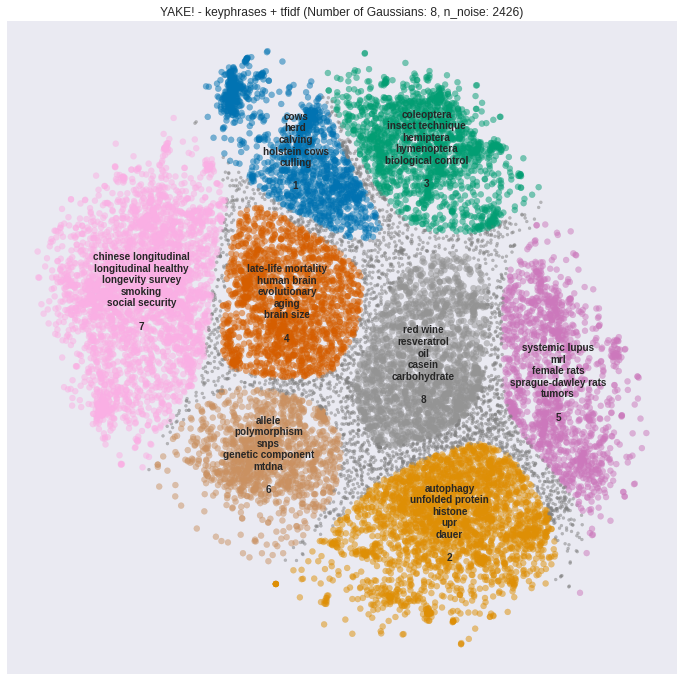

In [21]:
_ = create_plot(yake_phrases, ellipses=False, title='YAKE! - keyphrases + tfidf', tfidf=True, sublinear_tf=True)